In [39]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [40]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [41]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [42]:
from gradient_solver import construct_distance_matrix

In [43]:
import timeit

In [44]:
from IPython.display import display, Math, Latex

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [46]:
from scipy.spatial.distance import correlation

In [47]:
from gradient_solver import *

In [48]:
'''df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]'''

'df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()\ndf_observable_distances: pd.DataFrame = pd.read_excel(\n    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",\n    index_col=0\n)\nfeatures: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())\n\n# Ensure that both datasets contain the same indices\nvalid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)\ndf_explainable = df_explainable.loc[valid_indices]\ndf_observable_distances = df_observable_distances.loc[valid_indices]'

In [49]:
##################
# Synthetic Data #
##################

def uniform_list(von, bis, num):
    lis = list(Uniform(von, bis).sample([num]))
    return [float(li) for li in lis]

N = 100
z_N = 10
z_age = [float(li) for li in (uniform_list(0.9/(z_N-1), 0.999/(z_N-1), z_N) * np.arange(z_N))]
_z_age = uniform_list(0.0001, 0.9999, N-z_N)
dummy_explainables = pd.DataFrame({
    'Age': z_age + _z_age,
    'Weight': Uniform(0, 1).sample([N]),
    'Is_a_Zebra': uniform_list(0.9967, 0.9999, z_N) + uniform_list(0.0005, 0.0013, N-z_N),
    'Loves_to_sleep': Uniform(0,1).sample([N]),
    'Noise_1': Uniform(0,1).sample([N]),
    'Noise_2': Uniform(0,1).sample([N]),
    'Noise_3': Uniform(0,1).sample([N]),
    'Noise_4': Uniform(0,1).sample([N]),
    'Noise_5': Uniform(0,1).sample([N]),
}, index = [f'Individual_{i}' for i in range(N)])

K = 20
lis = []
for k in range(K):
    lis = lis + [z+u for z,u in zip(z_age, uniform_list(0.0001, 0.0150, z_N))] + uniform_list(0.0001, 0.9999, N-z_N)

dummy_observables = pd.DataFrame({
    'Individual': [f'Individual_{n}' for n in range(N)] * K,
    'if_zebra_then_age': lis,
    'unexplainable_1': Uniform(0,1).sample([N*K])
})

showcase_df = dummy_observables.copy()
for individual in showcase_df.Individual.unique():
    idx = showcase_df.query(f'Individual == "{individual}"').index
    showcase_df.loc[idx, 'Age'] = dummy_explainables.loc[individual].Age
    showcase_df.loc[idx, 'Zebra'] = dummy_explainables.loc[individual].Is_a_Zebra
    showcase_df.loc[idx, 'bool_Zebra'] = dummy_explainables.loc[individual].Is_a_Zebra > 0.5

Text(0, 0.5, 'Feature_2')

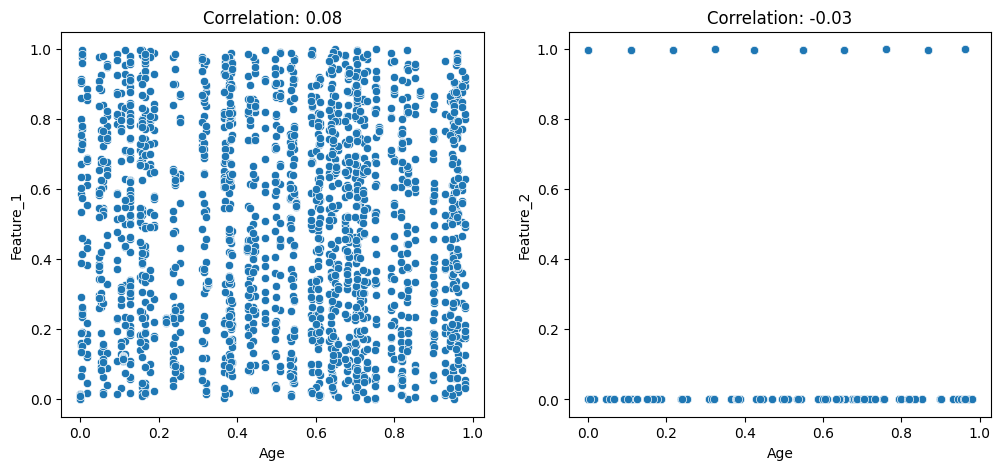

In [50]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12,5)

izta = sns.scatterplot(
    x = showcase_df.Age,
    y = showcase_df.if_zebra_then_age,
    ax = axes[0]
)

corr = np.corrcoef(showcase_df.Age.to_numpy().flatten(), showcase_df.if_zebra_then_age.to_numpy().flatten())[0][1]
izta.set_title(f'Correlation: {corr:.2f}')

izta.set_ylabel('Feature_1')

iaz = sns.scatterplot(
    x = showcase_df.Age,
    y = showcase_df.Zebra,
    ax = axes[1]
)


corr = np.corrcoef(showcase_df.Age.to_numpy().flatten(), showcase_df.Zebra.to_numpy().flatten())[0][1]
iaz.set_title(f'Correlation: {corr:.2f}')

iaz.set_ylabel('Feature_2')

<Axes: xlabel='Age', ylabel='if_zebra_then_age'>

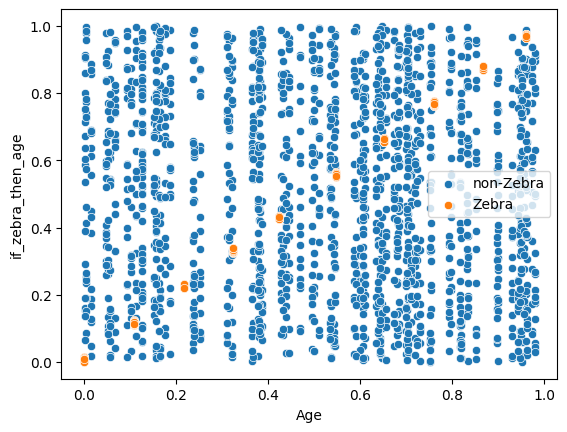

In [51]:
sns.scatterplot(
    x = showcase_df.Age[~showcase_df.bool_Zebra],
    y = showcase_df.if_zebra_then_age[~showcase_df.bool_Zebra],
    label='non-Zebra'
)
sns.scatterplot(
    x = showcase_df.Age[showcase_df.bool_Zebra],
    y = showcase_df.if_zebra_then_age[showcase_df.bool_Zebra],
    label='Zebra'
)

In [52]:
index_name = 'Individual'

df_observable = dummy_observables
df_explainable = dummy_explainables

observed_features = []
for f in df_observable:
    if f != index_name:
        observed_features.append(f)

explaining_features = []
for f in df_explainable:
    if f != index_name:
        explaining_features.append(f)       

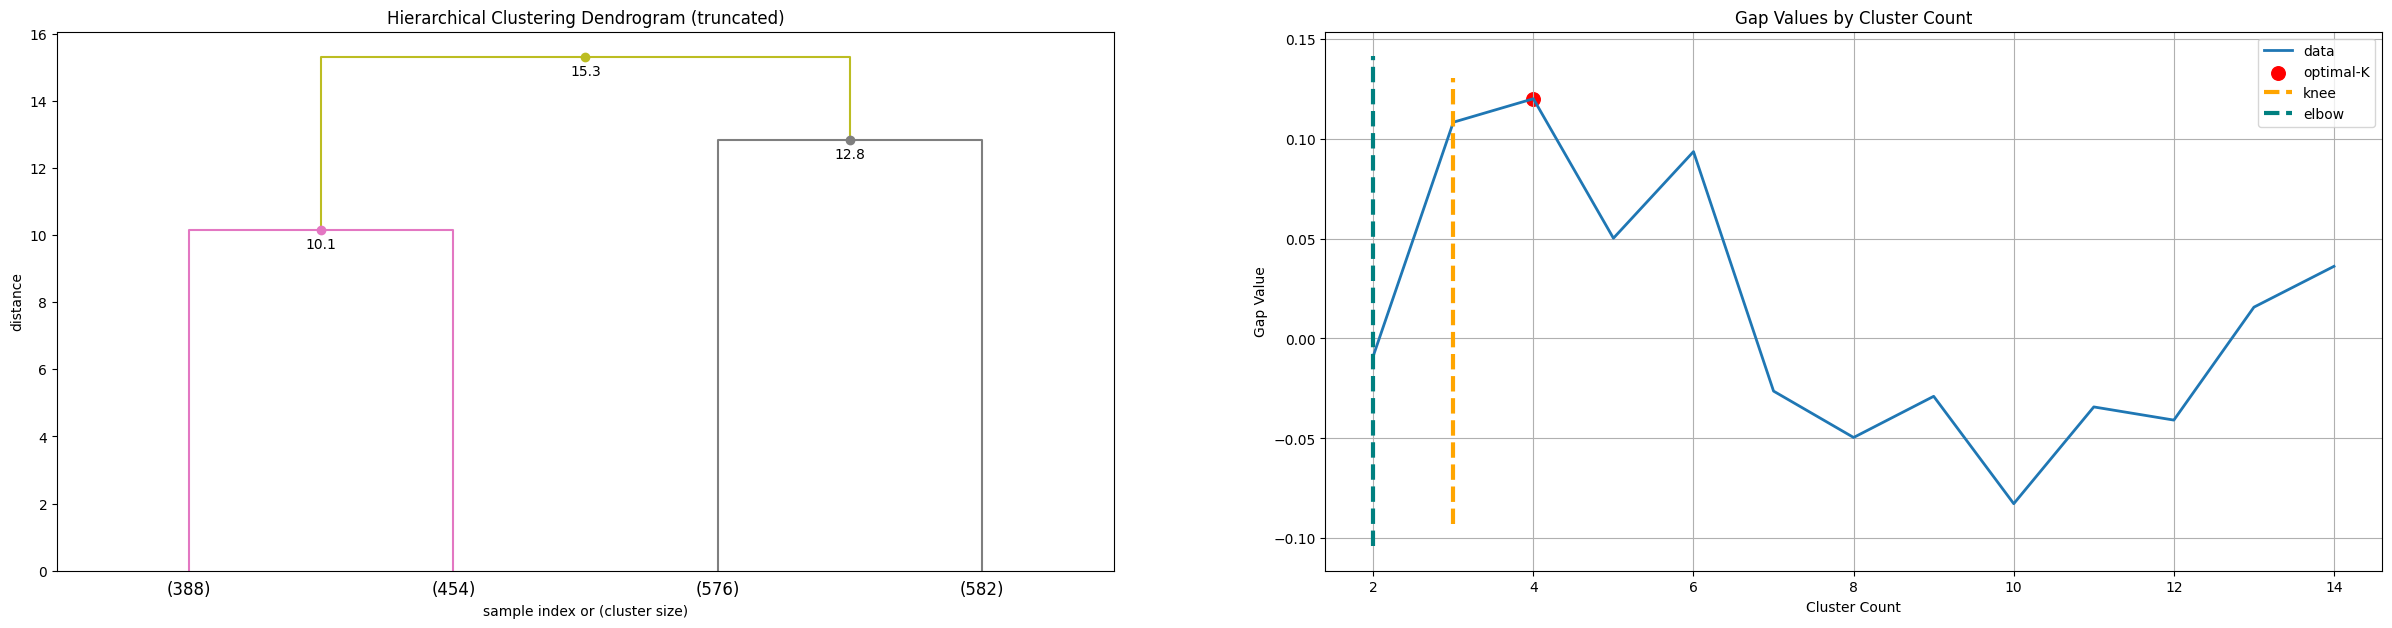

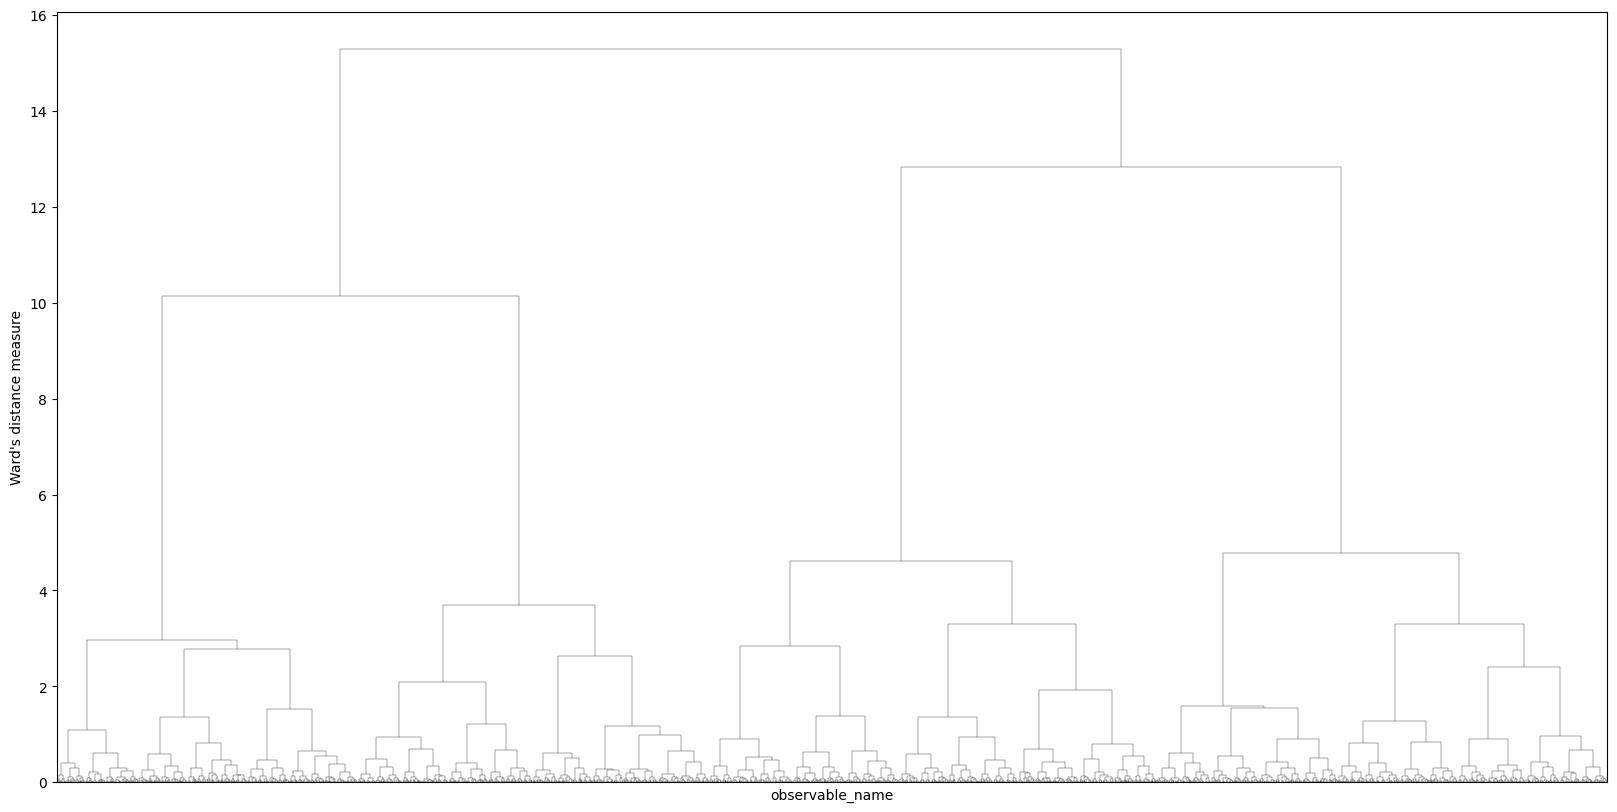

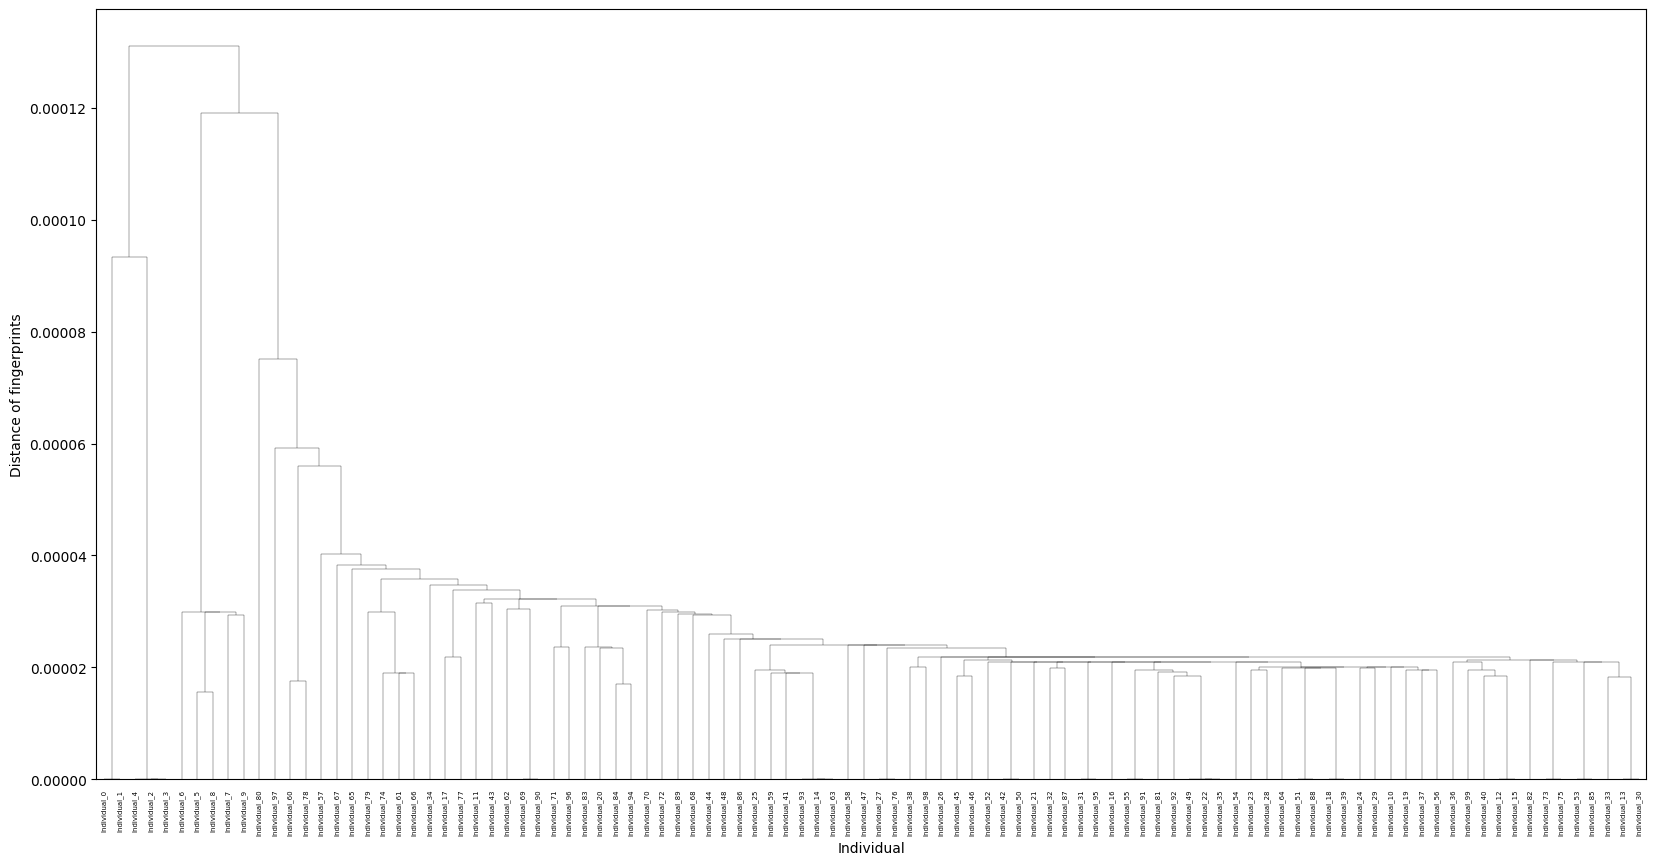

In [53]:
my_linkage = 'ward'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.01,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters= optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [54]:
observable_patterns_result['spider_plots']

  0%|          | 0/511 [00:00<?, ?it/s]

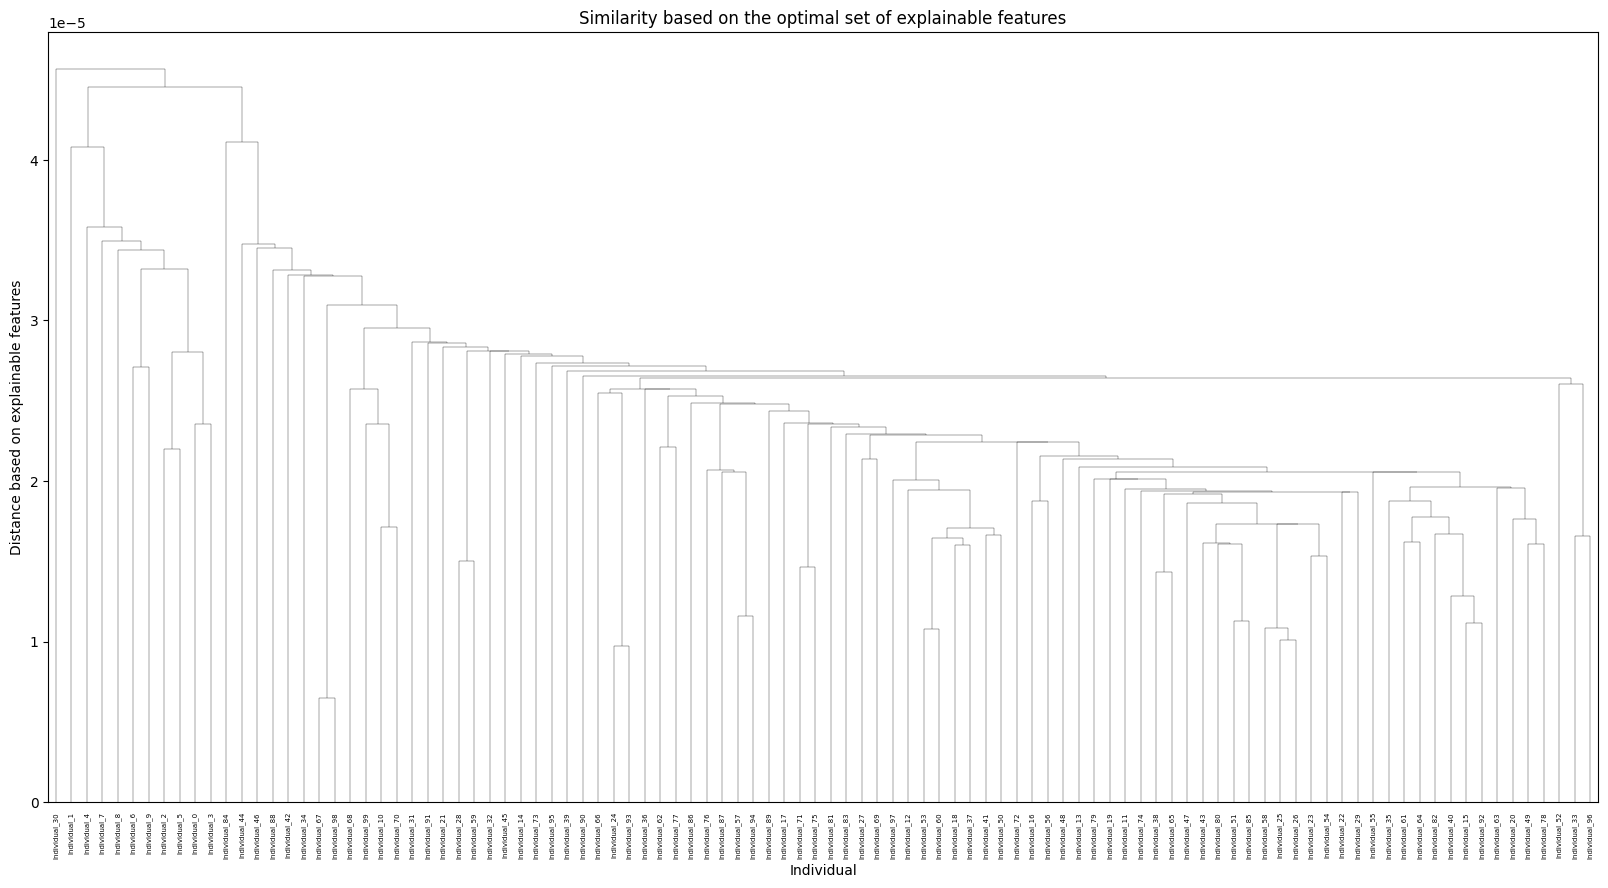

In [58]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy().set_index('index'),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.0,
    max_num_threads=12,
    group_name=index_name
)

In [60]:
calculate_explainable_distances_result['overview_df']

,correlation,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
0,0.745481,0,0,1,0,0,0,1,0,0


In [61]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0       True
1       True
2       True
3       True
4       True
        ... 
1995    True
1996    True
1997    True
1998    True
1999    True
Name: pattern_type, Length: 2000, dtype: bool
0.952
[0 3 3 3 3 2 1 2 2 1 2 0 3 3 1 2 0 2 1 0 0 2 3]
[0 3 3 3 3 2 1 2 2 1 2 0 3 3 1 2 0 2 1 0 0 2 3]


In [62]:
...

Ellipsis